In [1]:
# Install the CKAN API
!pip install ckanapi

In [2]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

%matplotlib inline

import seaborn as sns
from datetime import datetime
import calendar
import requests
from ckanapi import RemoteCKAN


Configure the [CKAN API](https://github.com/ckan/ckanapi) to connect to [data.dundeecity.gov.uk](https://data.dundeecity.gov.uk), Dundee's CKAN instance. 

In [3]:
# get database from website
dd = RemoteCKAN('https://data.dundeecity.gov.uk')
# get datasets (in dictionary format) from the database

# charge session 1 from 01/09/17 to 01/12/17 - 3 months
chs1_dict = dd.action.datastore_search(resource_id='d748579a-f05f-47e6-a76b-e76d1e2e9589', limit=20000)
# charge session 2 from 02/12/17 to 02/03/18 - 3 months
chs2_dict = dd.action.datastore_search(resource_id='d2bf2085-922f-4c29-9682-788fb47b5b4d', limit=20000)
# charge session 3 from 05/03/18 to 05/06/18 - 3 months
chs3_dict = dd.action.datastore_search(resource_id='f4c07f77-39f8-4f1b-9477-225d893dcf80', limit=20000)
# charge session 4 from 06/06/18 to 06/09/18 - 3 months
chs4_dict = dd.action.datastore_search(resource_id='dd6186a4-5d1a-431a-93c4-0be142ff8e10', limit=20000)
# charge point locations
cpl_dict = dd.action.datastore_search(resource_id='bf478c38-9aa4-44b4-943a-77d643149a74', limit=20000)

In [4]:
# convert to Pandas DataFrame
chs1_df = pd.DataFrame(chs1_dict['records'])
chs2_df = pd.DataFrame(chs2_dict['records'])
chs3_df = pd.DataFrame(chs3_dict['records'])
chs4_df = pd.DataFrame(chs4_dict['records'])
chs = pd.concat([chs1_df, chs2_df, chs3_df, chs4_df]) #charge sessions
cpl = pd.DataFrame(cpl_dict['records']) #charge point locations

In [5]:
chs.head()

,CP ID,Charging event,Connector,Cost,End Date,End Time,Group,Model,Site,Start Date,Start Time,Total kWh,User ID,_id
0,NaN,4032911,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,,2017-01-12T00:00:00,12:09,NaN,NaN,1
1,NaN,4032912,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT 7kW Dual Outlet,,2017-01-12T00:00:00,12:09,NaN,NaN,2
2,50269.0,4032900,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT 7kW Dual Outlet,"Housing Office East, Dundee",2017-01-12T00:00:00,12:07,NaN,NaN,3
3,50523.0,4032891,1,NaN,None,,APT Controls; CYC; Dundee City Council; Charge...,APT 7kW Dual Outlet,"Marchbanks, Dundee",2017-01-12T00:00:00,12:03,NaN,NaN,4
4,50338.0,4032879,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,"Social Work Building, Jack Martin Way, Dundee",2017-01-12T00:00:00,12:00,NaN,NaN,5


In [6]:
cpl.head()

,Address,CP ID,Charging_cards_accepted,F24_Hours,Latitude,Location,Longitude,Times,Type,_id,locationShortDescription
0,"1B Sinclair Street, DD2 3BW",51085,Charge Place Scotland,PUBLIC 24hr,56.472965,"Housing Office West, Dundee",-3.011193,,Slow,1,
1,"3 Explorer Road, Dundee, DED2 1EG",SCO50884,Charge Place Scotland,HILLCREST VEHICLES,56.469833,Hillcrest Housing Association,-3.057191,Unknown,Fast,2,
2,Lothian Crescent,50264,Charge Place Scotland,PUBLIC,56.489829,Whitfield Centre,-2.917475,Free to park & charge,Slow,3,
3,Lothian Crescent,50263,Charge Place Scotland,PUBLIC,56.489722,Whitfield Centre,-2.917516,Free to park & charge,Slow,4,
4,"Gellatly Street, Dundee, DD1 3RB",50274,Charge Place Scotland,PUBLIC 08:00 - 18:00 Sun: 13:00 - 18:00,56.461497,Gellatly Street Car Park,-2.966478,(Registered) fully electric vehicles free to p...,Fast,5,


## 1. Clean charge sessions dataset

In [7]:
# drop missing data in chs
cols_w_missing_chs = [col for col in chs.columns if chs[col].isnull().any()]
chs = chs.dropna(axis=0, subset=cols_w_missing_chs)
chs['CP ID'] = chs['CP ID'].astype('int64')
unique_CPID = chs['CP ID'].unique() # CPs that are actually used

In [8]:
# calibrate 'Site' in chs
chs.loc[chs.Site.str.contains('Sinclair Street'), 'Site'] = 'Sinclair Street, Dundee'
chs.loc[chs.Site.str.contains('South Tay Street'), 'Site'] = 'South Tay Street, Dundee'
chs.loc[chs.Site.str.contains('Trades Lane'), 'Site'] ='Trades Lane, Dundee'

In [9]:
# convert datetime type
# Use `to_datetime` function to convert date & time columns into a datetime object
start_timestamp = chs['Start Date'].str.slice(0,10) + ' ' + chs['Start Time']
# add new column 'StartDateTime'
chs['StartDateTime'] = pd.to_datetime(start_timestamp, format='%Y-%m-%d %H:%M')
end_timestamp = chs['End Date'].str.slice(0,10) + ' ' + chs['End Time']
# add new column 'EndDateTime'
chs['EndDateTime'] = pd.to_datetime(end_timestamp, format='%Y-%m-%d %H:%M')
chs = chs.drop(columns=['Start Date','Start Time','End Date','End Time'])[[
    'CP ID', 
    'Model', 
    'Total kWh', 
    'StartDateTime', 
    'EndDateTime', 
    'Site', 
    'Cost', 
    'User ID', 
    'Charging event', 
    'Connector']]

In [10]:
# Encode 'Model' as 'Slow', 'Fast' and 'Rapid'
chs.loc[chs.Model.str.contains('Rapid | 50kW'), 'Model'] = 'Rapid'
chs.loc[chs.Model.str.contains('22kW'), 'Model'] = 'Fast'
chs.loc[chs.Model.str.contains('7kW'), 'Model'] = 'Slow'

## 2. Clean charge point location dataset

In [11]:
# drop missing data in cpl
cols_w_missing_cpl = [col for col in cpl.columns if cpl[col].isnull().any()]
cpl = cpl.dropna(axis=0, subset=cols_w_missing_cpl)

# convert CP ID to integer in cpl
if cpl['CP ID'].dtypes == object:
    cpl = cpl[cpl['CP ID'].str.isnumeric()]
    cpl['CP ID'] = cpl['CP ID'].astype('int64')
# there are 63 CPs used, but only 48 of them have a record/address 
# cpl_df.loc[cpl_df['CP ID'].isin(unique_CPID)]
cpl = cpl[['CP ID', 'Type', 'Latitude', 'Longitude', 'Location', 'Address',
          'F24_Hours', 'Times']]

### Preview datasets and save to .cvs files

In [12]:
chs[0:2]

,CP ID,Model,Total kWh,StartDateTime,EndDateTime,Site,Cost,User ID,Charging event,Connector
0,50914,Fast,22.287,2018-06-09 23:55:00,2018-07-09 07:03:00,"Lochee Charging Hub, Dundee",0.0,601838,7751157,1
1,50349,Rapid,7.080,2018-06-09 23:38:00,2018-06-09 23:48:00,"Greenmarket Multi Car Park, Dundee",0.0,604982,7751142,2


In [13]:
cpl[0:2]

,CP ID,Type,Latitude,Longitude,Location,Address,F24_Hours,Times
0,51085,Slow,56.472965,-3.011193,"Housing Office West, Dundee","1B Sinclair Street, DD2 3BW",PUBLIC 24hr,
2,50264,Slow,56.489829,-2.917475,Whitfield Centre,Lothian Crescent,PUBLIC,Free to park & charge


In [14]:
# save charge sessions and charge point location into .csv files
chs.to_csv('chargesession_010917-060918.csv')
cpl.to_csv('chargepointlocation.csv')

## 3. Data Analysis / Statistics 
> 
* Charging Sessions count - to show which site is the busiest
* Energy Consumption count

### Total charge sessions count by site

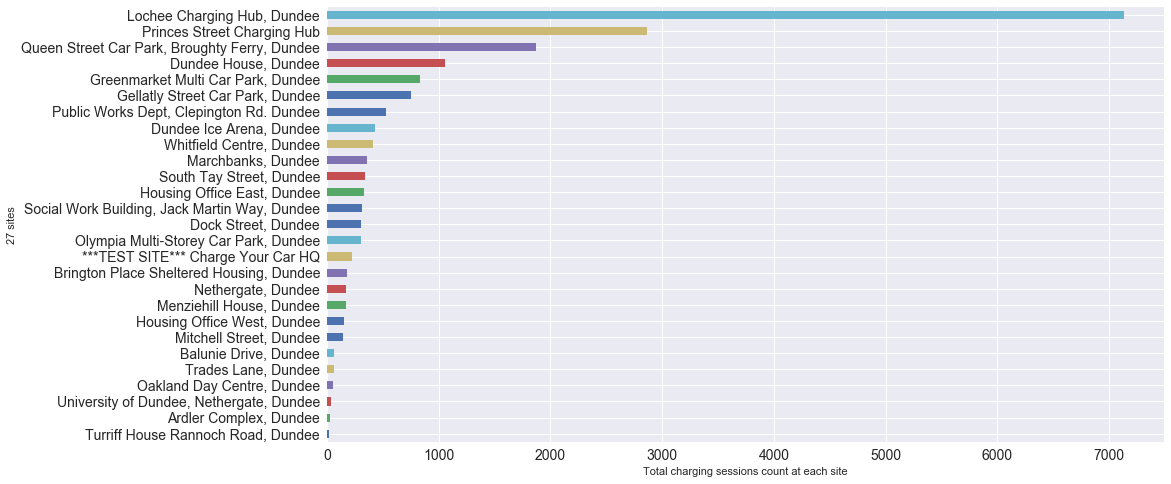

In [15]:
chs_by_site = chs.groupby('Site').size().sort_values()

# plot
num_of_site = chs_by_site.size
fig, ax = plt.subplots(figsize=(15,8))
ax = chs_by_site.plot(x='Site', kind='barh', fontsize=14)
ax.set_xlabel('Total charging sessions count at each site')
ax.set_ylabel('{} sites'.format(num_of_site))
fig.savefig('Total_sessions_by_site.png')

### Charge sessions trend over time

Text(0.5,1,'Total weekly energy consumptions [kWh]')

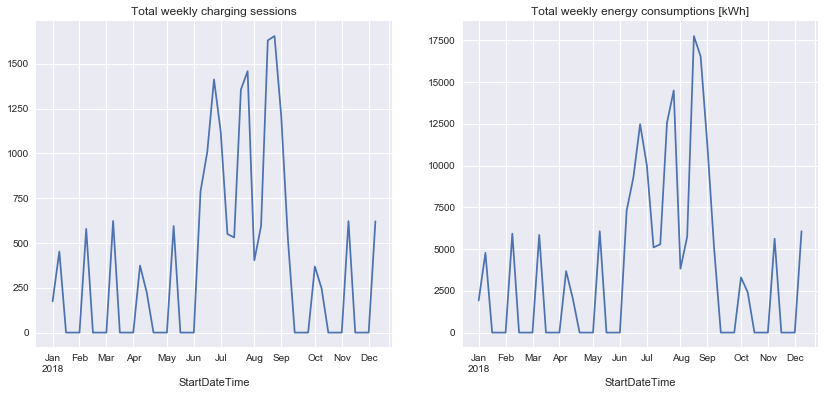

In [16]:
# set StartDateTime as index
chs = chs.set_index(chs.StartDateTime)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

chs['Charging event'].resample('W').size().plot(ax = ax[0])

chs['Total kWh'].resample('W').sum().plot(ax = ax[1])

ax[0].set_title('Total weekly charging sessions')
ax[1].set_title('Total weekly energy consumptions [kWh]')


### Hourly charge sessions count
> Sum over all types of charge points, all sites, and all day regardless weekday and weekend

In [17]:
# add more columns
chs['DayofWeek'] = chs.index.dayofweek
chs['DayofWeekName'] = chs.index.weekday_name
chs['StartHour'] = chs.index.hour

Text(0.5,1,'Hourly charge sessions count')

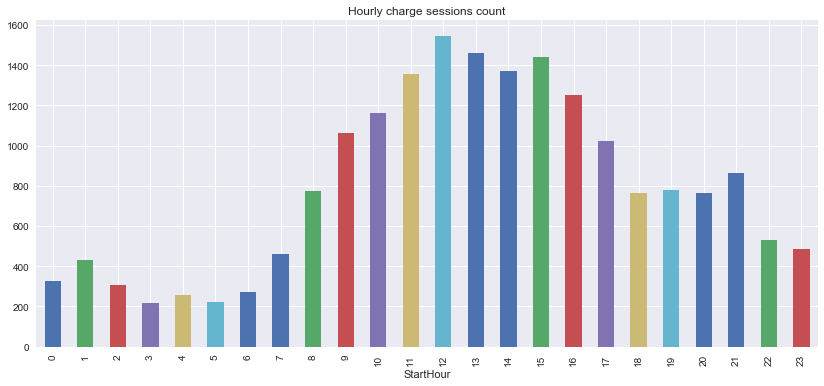

In [18]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(14,6))
chs.groupby(['StartHour']).size().plot(kind='bar')
ax.set_title('Hourly charge sessions count')

### Are there patterns of busy hours?
> Does this vary by 
* Day of week
* Type of charge points

In [19]:
pivoted = chs.pivot_table(index=chs.StartHour, columns=chs.index.date, values=['Charging event'], aggfunc={'Charging event':len}, fill_value=0)
pivoted.iloc[:5, :5]

Charging event                                            
              2018-01-07 2018-01-08 2018-01-09 2018-02-07 2018-02-08
StartHour                                                           
0                      5          4          4          2          5
1                      9          4         12          2          3
2                      7          1         10          1          2
3                      5          1          6          5          0
4                      8          4          2          3          1

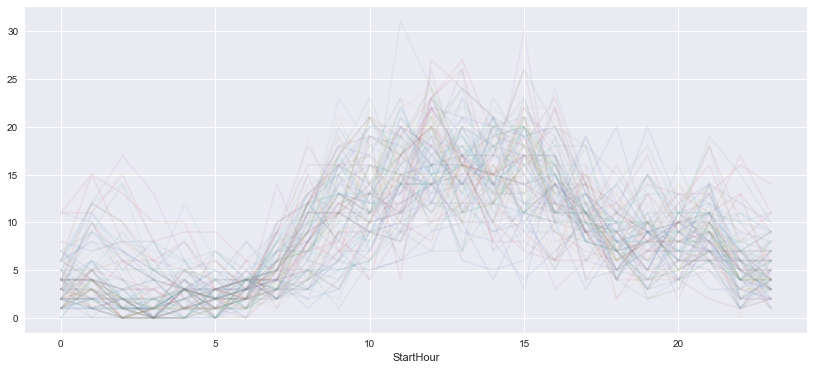

In [20]:
pivoted.plot(legend=False, alpha=0.08, figsize=(14,6))
# each line represents each day
# the value is number of charge events on each day at each hour

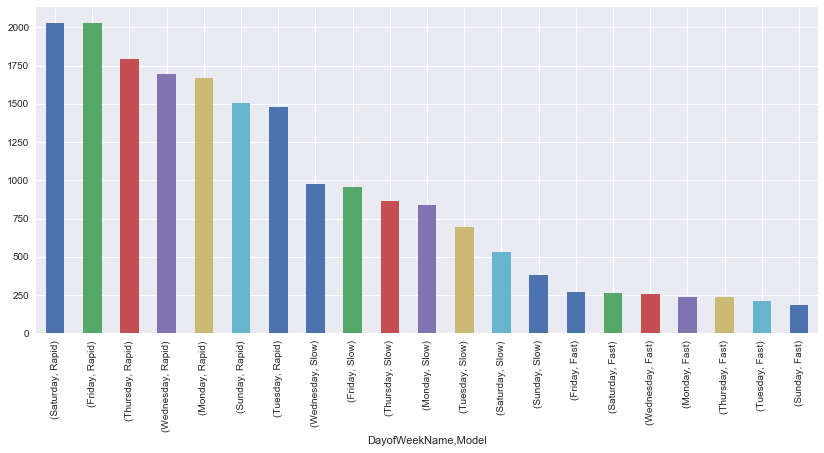

In [21]:
chs.groupby(['DayofWeekName', 'Model']).size().sort_values(ascending=False).plot(kind='bar',figsize=(14,6))

In [22]:
chs.groupby('Model').size()

Model
Fast      1667
Rapid    12204
Slow      5244
dtype: int64

Text(0.5,1,'Total charge sessions at slow CPs')

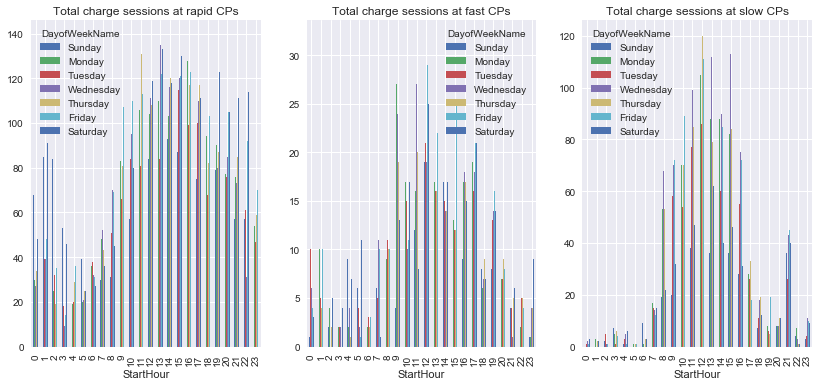

In [23]:
rapid = chs[chs['Model']=='Rapid']
fast = chs[chs['Model']=='Fast']
slow = chs[chs['Model']=='Slow']

#reshape the dataframe in a pivot table
pivoted_r = rapid.pivot_table(values='Charging event', 
                              index='StartHour', 
                              columns='DayofWeekName', 
                              aggfunc=len)
pivoted_r = pivoted_r[['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]
# pivoted_r.iloc[:5,:7]

pivoted_f = fast.pivot_table(values='Charging event',
                            index='StartHour',
                            columns='DayofWeekName',
                            aggfunc=len)
pivoted_f = pivoted_f[['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]

pivoted_s = slow.pivot_table(values='Charging event',
                            index='StartHour',
                            columns='DayofWeekName',
                            aggfunc=len)
pivoted_s = pivoted_s[['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]

# plot
fig, ax = plt.subplots(1, 3, figsize=(14,6))
ax[0] = pivoted_r.plot(kind='bar', ax = ax[0])
ax[0].set_title('Total charge sessions at rapid CPs')
ax[1] = pivoted_f.plot(kind='bar', ax = ax[1])
ax[1].set_title('Total charge sessions at fast CPs')
ax[2] = pivoted_s.plot(kind='bar', ax = ax[2])
ax[2].set_title('Total charge sessions at slow CPs')


In [24]:
rapid.head()

,CP ID,Model,Total kWh,StartDateTime,EndDateTime,Site,Cost,User ID,Charging event,Connector,DayofWeek,DayofWeekName,StartHour
StartDateTime,,,,,,,,,,,,,
2018-06-09 23:38:00,50349,Rapid,7.080,2018-06-09 23:38:00,2018-06-09 23:48:00,"Greenmarket Multi Car Park, Dundee",0.0,604982,7751142,2,5,Saturday,23
2018-06-09 23:36:00,50911,Rapid,8.220,2018-06-09 23:36:00,2018-06-09 23:56:00,"Queen Street Car Park, Broughty Ferry, Dundee",0.0,603522H,7751140,2,5,Saturday,23
2018-06-09 23:14:00,51548,Rapid,4.494,2018-06-09 23:14:00,2018-06-09 23:21:00,"Lochee Charging Hub, Dundee",0.0,608230,7751125,2,5,Saturday,23
2018-06-09 23:00:00,51549,Rapid,10.292,2018-06-09 23:00:00,2018-06-09 23:14:00,"Lochee Charging Hub, Dundee",0.0,606666,7751116,2,5,Saturday,23
2018-06-09 22:56:00,51547,Rapid,32.023,2018-06-09 22:56:00,2018-06-09 23:56:00,"Lochee Charging Hub, Dundee",0.0,608557,7751112,2,5,Saturday,22


Text(0.5,1,'Charge Sessions at slow CPs')

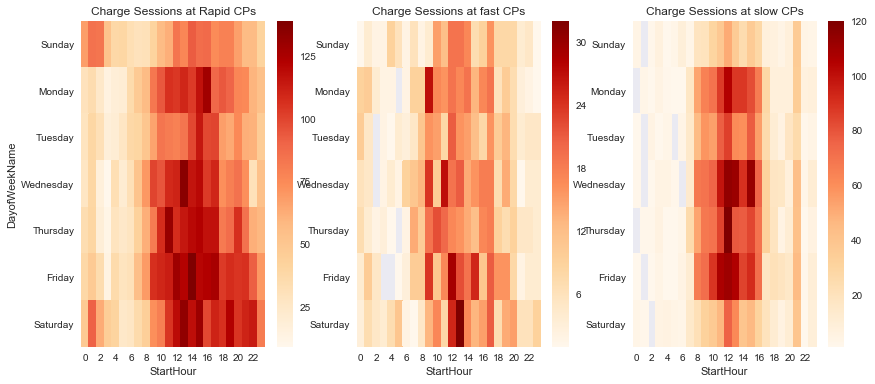

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(14,6))
ax[0] = sns.heatmap(pivoted_r.T, ax = ax[0], xticklabels=2, cmap='OrRd')
ax[0].set_title('Charge Sessions at Rapid CPs')

ax[1] = sns.heatmap(pivoted_f.T, ax = ax[1], xticklabels=2, cmap='OrRd')
ax[1].set_title('Charge Sessions at fast CPs')

ax[2] = sns.heatmap(pivoted_s.T, ax = ax[2], xticklabels=2, cmap='OrRd' )
ax[2].set_title("Charge Sessions at slow CPs")

### By total power consumption at each site
> If a session doesn't end correctly, there will be no power consumption recorded. Filter out those who have NaN power consumption values.

Text(0,0.5,'27 sites')

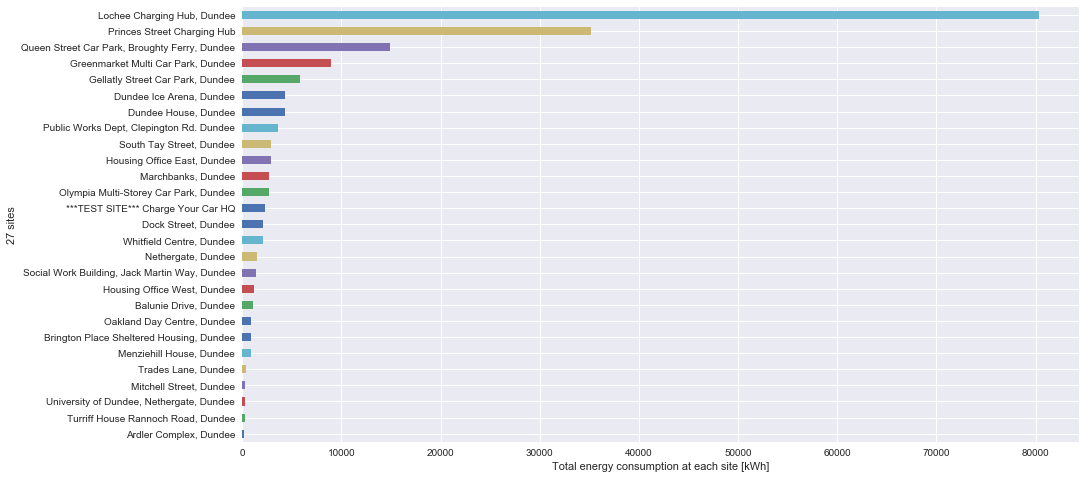

In [26]:
consump_by_site = chs[chs['Total kWh'].notnull()].groupby(['Site'])['Total kWh'].sum().sort_values()
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax = consump_by_site.plot(x='Site', y='TotalkWh', kind='barh')
ax.set_xlabel('Total energy consumption at each site [kWh]')
ax.set_ylabel('{} sites'.format(num_of_site))
# fig.savefig('consump_at_site.png')

Text(0.5,1,'Total energy consumption [kWh]')

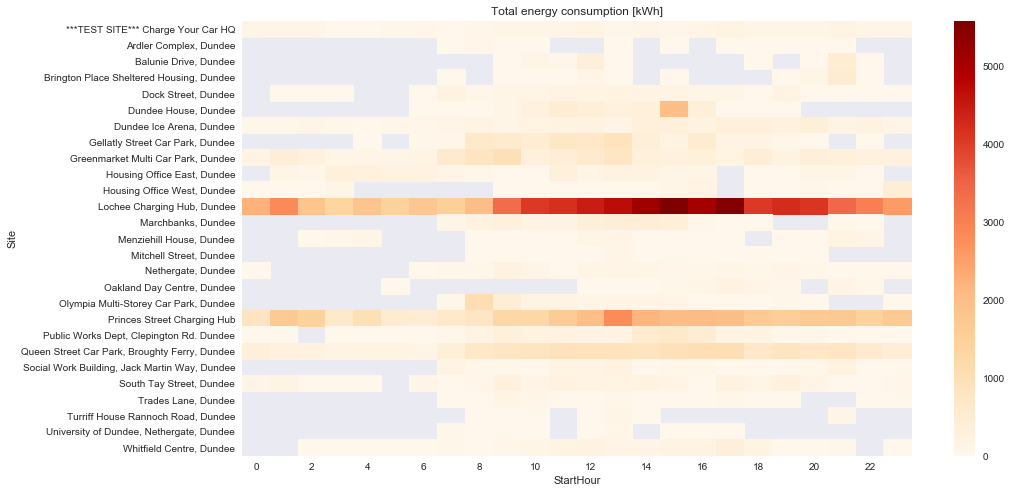

In [27]:
# total consumption per hour
consump = chs[chs['Total kWh'].notnull()].sort_index()

pivoted_consump = consump.pivot_table(index='Site',
                                      columns='StartHour',
                                      values='Total kWh',
                                      aggfunc=sum)

fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax = sns.heatmap(pivoted_consump, xticklabels=2, cmap='OrRd' )
ax.set_title("Total energy consumption [kWh]")
# plt.tight_layout()
# fig.savefig("ConsumptionHeatMap.png")

In [28]:
# consump['EndDateTime']-consump['StartDateTime'] -> negative values -> data need calibration
# slow:7kW fast:22kW rapid:50kW 
# calculate the acutal charging duration of each session
# e.g., If model=rapid, then DurHour=TotalkWh/50
if chs.index.name != 'Charging event':
    a = chs.set_index('Charging event').sort_values('StartDateTime')
df_1 = (a[a['Model']=='Rapid']['Total kWh']/50)*60
df_2 = (a[a['Model']=='Fast']['Total kWh']/22)*60
df_3 = (a[a['Model']=='Slow']['Total kWh']/7)*60

a['ChargeDurationMins'] = pd.concat([df_1, df_2, df_3])
chs=a
chs.head()

,CP ID,Model,Total kWh,StartDateTime,EndDateTime,Site,Cost,User ID,Connector,DayofWeek,DayofWeekName,StartHour,ChargeDurationMins
Charging event,,,,,,,,,,,,,
7383613,51550,Rapid,24.676,2018-01-07 00:04:00,2018-01-07 00:38:00,"Lochee Charging Hub, Dundee",0.0,605432,2,6,Sunday,0,29.611200
7383615,51087,Slow,0.000,2018-01-07 00:05:00,2018-01-07 00:20:00,"Queen Street Car Park, Broughty Ferry, Dundee",0.0,518009,1,6,Sunday,0,0.000000
7383621,50911,Rapid,9.550,2018-01-07 00:21:00,2018-01-07 00:34:00,"Queen Street Car Park, Broughty Ferry, Dundee",0.0,518009,2,6,Sunday,0,11.460000
7383627,51086,Fast,5.750,2018-01-07 00:33:00,2018-01-07 11:29:00,"Nethergate, Dundee",0.0,503829,1,6,Sunday,0,15.681818
7383634,51548,Rapid,13.878,2018-01-07 00:49:00,2018-01-07 01:18:00,"Lochee Charging Hub, Dundee",0.0,604244,2,6,Sunday,0,16.653600


In [29]:
chs.to_pickle('chs_cleaned_v2.pkl')